# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
!pip install scikit-learn==0.20.0 # update sklearn to ensure libraries to work
import sklearn
print (sklearn.__version__)

    100% |████████████████████████████████| 5.3MB 6.5MB/s eta 0:00:01    33% |██████████▉                     | 1.8MB 14.3MB/s eta 0:00:01    68% |█████████████████████▉          | 3.6MB 21.7MB/s eta 0:00:01    90% |█████████████████████████████   | 4.8MB 27.1MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.19.1
    Uninstalling scikit-learn-0.19.1:
      Successfully uninstalled scikit-learn-0.19.1
0.20.0


/opt/conda/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [4]:
# load required library 

# additional libraries 
import matplotlib as plt

# building the model 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model  import LogisticRegression

from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.base import BaseEstimator,TransformerMixin

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## Data Cleaning

### Portfolio

In [5]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
portfolio_df = portfolio.merge(pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0),left_index=True, right_index=True)

In [8]:
portfolio_df.head(3)

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1


In [9]:
portfolio_df = pd.concat([portfolio_df,pd.get_dummies(portfolio_df['offer_type'])],axis=1)

In [10]:
portfolio_df

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


In [11]:
portfolio_df.describe()

,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000,1.0,0.900000,0.600000,0.800000,0.400000,0.400000,0.200000
std,5.831905,2.321398,3.583915,0.0,0.316228,0.516398,0.421637,0.516398,0.516398,0.421637
min,0.000000,3.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,5.000000,2.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,8.500000,7.000000,4.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,10.000000,7.000000,5.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,20.000000,10.000000,10.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Profile (customers profile)

In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [14]:
profile[['age','income']].describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


In [15]:
profile.shape

(17000, 5)

In [16]:
profile.isnull().sum() # shows a lot of missing value on gender and income

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

#### Data Visualization for profile

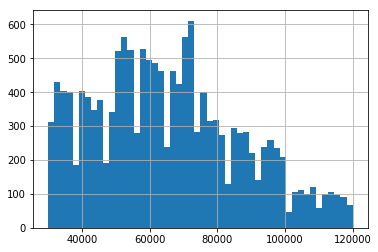

In [17]:
profile.income.hist(bins=50);

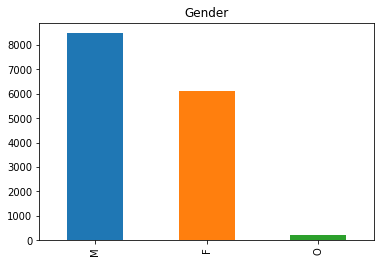

In [18]:
profile.gender.value_counts().plot(kind='bar', title='Gender');

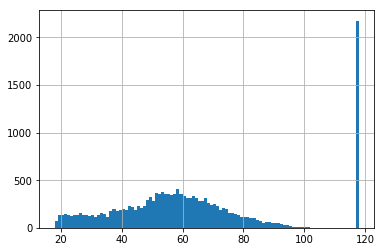

In [19]:
profile.age.hist(bins=100);

In [20]:
# age shows multiple 118 unrealistic values

In [21]:
profile[profile['age']==118].isnull().sum() # looking up age 118 seems that it comprises of all the missing values 

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [22]:
# removing age == 118 
profile_nonull = profile[~(profile.age == 118)]

In [23]:
profile_nonull.notnull().sum() # sample data should be enough to build a model

age                 14825
became_member_on    14825
gender              14825
id                  14825
income              14825
dtype: int64

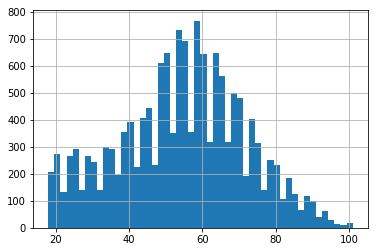

In [24]:
profile_nonull['age'].hist(bins=50); # normally distributed

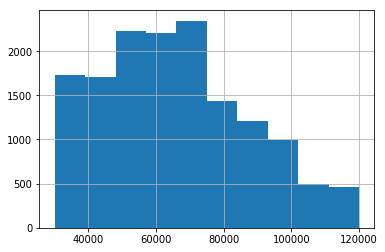

In [25]:
profile_nonull['income'].hist(); # right skewed

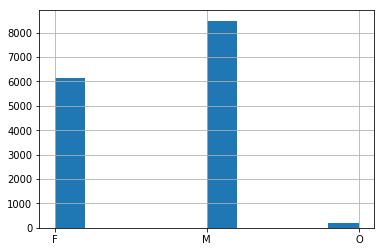

In [26]:
profile_nonull['gender'].hist(); # right skewed

In [27]:
profile_nonull.duplicated().sum() # check for dups

0

### Transactional Data

In [28]:
transcript.notnull().sum() 

event     306534
person    306534
time      306534
value     306534
dtype: int64

In [29]:
# check out number of unique person
transcript.person.nunique()

17000

In [30]:
# verify if sample data is still enoungh to achieve objectives 

# number of person left after removing null values on profile (87.20%) which is still enough
pd.DataFrame(transcript.person).merge(profile_nonull,left_on='person',right_on='id',how='inner')['person'].nunique() / transcript.person.nunique()

0.8720588235294118

In [31]:
# check for nulls 
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [32]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


#### Data Visualization for histogram

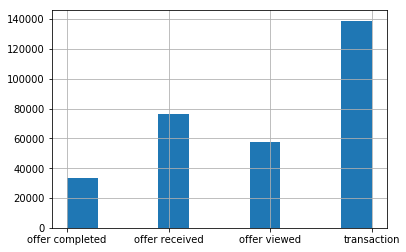

In [33]:
transcript.event.hist();

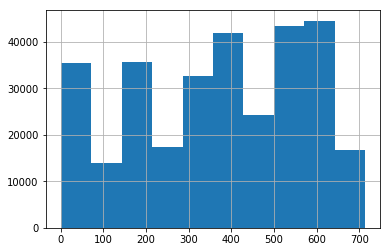

In [34]:
transcript.time.hist()

In [35]:
transcript.shape

(306534, 4)

In [36]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [37]:
transcript[transcript.event == 'transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [38]:
transcript[transcript.event == 'offer completed'].head() # notice that offer id has an "underscore"

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [39]:
transcript[transcript.event == 'offer viewed'].head() # viewed does not have underscore

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [40]:
transcript[transcript.event == 'offer received'].head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [41]:
# check an individual level
transcript[transcript.person=='78afa995795e4d85b5d9ceeca43f5fef']

# shows an overview on what happens on a transaction
# offer recieved -> offer viewed -> transaction -> offer completed


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [42]:
# merging the profile and the transcript together

In [43]:
df = transcript.merge(profile_nonull,left_on='person',right_on='id',how='inner')

In [44]:
df.value.apply(lambda x: x.keys()).value_counts() # checking for other keys in the dic

# offer completed shows a reward attached to it. 

(amount)              123956
(offer id)            116360
(offer_id, reward)     32443
(offer id)                 1
(offer_id, reward)         1
(amount)                   1
Name: value, dtype: int64

In [45]:
def return_offer_val(x):
    for key, value in x.items():
        if key in ['offer id','offer_id']:
            return value
    return(None)


def return_amount(x):
    for key, value in x.items():
        if key in ['amount']:
            return value
    return(None)

def return_reward(x):
    for key, value in x.items():
        if key in ['reward']:
            return value
    return(None)

In [46]:
df['offer_id'] = df.value.apply(lambda x: return_offer_val(x))
df['amount'] = df.value.apply(lambda x: return_amount(x))
df['reward_transactions'] = df.value.apply(lambda x: return_reward(x))

In [47]:
df

,event,person,time,value,age,became_member_on,gender,id,income,offer_id,amount,reward_transactions
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,None,19.89,NaN
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,None,17.78,NaN
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
7,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,None,19.67,NaN
8,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,None,29.72,NaN
9,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,None,23.93,NaN


In [43]:
df['amount'].describe() # understand what the amount values

count    123957.000000
mean         13.996325
std          31.749420
min           0.050000
25%           3.660000
50%          10.800000
75%          19.130000
max        1062.280000
Name: amount, dtype: float64

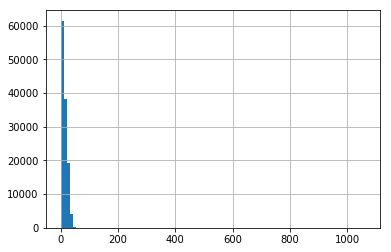

In [44]:
df['amount'].hist(bins=100) # checking the distribution

In [45]:
df['reward_transactions'].unique()

array([ nan,   5.,  10.,   2.,   3.])

In [46]:
df['reward_transactions'].describe() 

count    32444.000000
mean         4.948249
std          2.905376
min          2.000000
25%          2.000000
50%          5.000000
75%          5.000000
max         10.000000
Name: reward_transactions, dtype: float64

In [47]:
df.drop(columns='id',inplace=True)

# Merging the data together

In [48]:
df_all = df.merge(portfolio_df, left_on='offer_id',right_on='id')

In [49]:
df_all.columns

Index(['event', 'person', 'time', 'value', 'age', 'became_member_on', 'gender',
       'income', 'offer_id', 'amount', 'reward_transactions', 'channels',
       'difficulty', 'duration', 'id', 'offer_type', 'reward', 'email',
       'mobile', 'social', 'web', 'bogo', 'discount', 'informational'],
      dtype='object')

In [50]:
df_all.groupby(['offer_type', 'event'])['person'].count()

offer_type     event          
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: person, dtype: int64

In [51]:

df_all

,event,person,time,value,age,became_member_on,gender,income,offer_id,amount,...,id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,75,20170509,F,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
3,offer received,e2127556f4f64592b11af22de27a7932,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},68,20180426,M,70000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},68,20180426,M,70000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
5,offer completed,e2127556f4f64592b11af22de27a7932,522,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,68,20180426,M,70000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
6,offer received,389bc3fa690240e798340f5a15918d5c,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},65,20180209,M,53000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
7,offer viewed,389bc3fa690240e798340f5a15918d5c,192,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},65,20180209,M,53000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
8,offer received,389bc3fa690240e798340f5a15918d5c,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},65,20180209,M,53000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
9,offer viewed,389bc3fa690240e798340f5a15918d5c,438,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},65,20180209,M,53000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0


In [52]:
# creating dummy variables
df_all = pd.concat([df_all, pd.get_dummies(df_all['event'])], axis=1)
df_all = pd.concat([df_all, pd.get_dummies(df_all['gender'])], axis=1)
# df_all = pd.concat([df_all, pd.get_dummies(df_all['offer_type'])], axis=1)

In [53]:
df_all.columns

Index(['event', 'person', 'time', 'value', 'age', 'became_member_on', 'gender',
       'income', 'offer_id', 'amount', 'reward_transactions', 'channels',
       'difficulty', 'duration', 'id', 'offer_type', 'reward', 'email',
       'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       'offer completed', 'offer received', 'offer viewed', 'F', 'M', 'O'],
      dtype='object')

In [54]:
df_all['time_in_days'] = df_all['time'] / 24 # convert to days

In [55]:
df_all

,event,person,time,value,age,became_member_on,gender,income,offer_id,amount,...,bogo,discount,informational,offer completed,offer received,offer viewed,F,M,O,time_in_days
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,1,0,0,0,1,0,1,0,0,0.00
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,1,0,0,0,0,1,1,0,0,0.25
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,75,20170509,F,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,1,0,0,1,0,0,1,0,0,5.50
3,offer received,e2127556f4f64592b11af22de27a7932,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},68,20180426,M,70000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,1,0,0,0,1,0,0,1,0,17.00
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},68,20180426,M,70000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,1,0,0,0,0,1,0,1,0,17.50
5,offer completed,e2127556f4f64592b11af22de27a7932,522,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,68,20180426,M,70000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,1,0,0,1,0,0,0,1,0,21.75
6,offer received,389bc3fa690240e798340f5a15918d5c,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},65,20180209,M,53000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,1,0,0,0,1,0,0,1,0,7.00
7,offer viewed,389bc3fa690240e798340f5a15918d5c,192,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},65,20180209,M,53000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,1,0,0,0,0,1,0,1,0,8.00
8,offer received,389bc3fa690240e798340f5a15918d5c,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},65,20180209,M,53000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,1,0,0,0,1,0,0,1,0,17.00
9,offer viewed,389bc3fa690240e798340f5a15918d5c,438,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},65,20180209,M,53000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,...,1,0,0,0,0,1,0,1,0,18.25


In [56]:
df_all.groupby(by=['person','offer_id']).sum().head()

time  age  \
person                           offer_id                                      
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  1152   66   
                                 3f207df678b143eea3cee63160fa8bed   708   66   
                                 5a8bc65990b245e5a138643cd4eb9837   360   66   
                                 f19421c1d4aa40978ebb69ca19b0e20d  1278   99   
                                 fafdcd668e3743c1bb461111dcafc2a4  1572   99   

                                                                   became_member_on  \
person                           offer_id                                             
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5          40340842   
                                 3f207df678b143eea3cee63160fa8bed          40340842   
                                 5a8bc65990b245e5a138643cd4eb9837          40340842   
                                 f19421c1d4aa40978ebb69ca19b0e20d          60511263   
                                 fafdcd668e3743c1bb461111dcafc2a4          60511263   

                                                                     income  \
person                           offer_id                                     
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  144000.0   
                                 3f207df678b143eea3cee63160fa8bed  144000.0   
                                 5a8bc65990b245e5a138643cd4eb9837  144000.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d  216000.0   
                                 fafdcd668e3743c1bb461111dcafc2a4  216000.0   

                                                                   amount  \
person                           offer_id                                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5     0.0   
                                 3f207df678b143eea3cee63160fa8bed     0.0   
                                 5a8bc65990b245e5a138643cd4eb9837     0.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d     0.0   
                                 fafdcd668e3743c1bb461111dcafc2a4     0.0   

                                                                   reward_transactions  \
person                           offer_id                                                
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5                  2.0   
                                 3f207df678b143eea3cee63160fa8bed                  0.0   
                                 5a8bc65990b245e5a138643cd4eb9837                  0.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d                  5.0   
                                 fafdcd668e3743c1bb461111dcafc2a4                  2.0   

                                                                   difficulty  \
person                           offer_id                                       
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5          20   
                                 3f207df678b143eea3cee63160fa8bed           0   
                                 5a8bc65990b245e5a138643cd4eb9837           0   
                                 f19421c1d4aa40978ebb69ca19b0e20d          15   
                                 fafdcd668e3743c1bb461111dcafc2a4          30   

                                                                   duration  \
person                           offer_id                                     
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5        14   
                                 3f207df678b143eea3cee63160fa8bed         8   
                                 5a8bc65990b245e5a138643cd4eb9837         6   
                                 f19421c1d4aa40978ebb69ca19b0e20d        15   
                                 fafdcd668e3743c1bb461111dcafc2a4        30   

                                                 

In [57]:
df_cust_offer = df_all.groupby(by=['person','offer_id']).sum()

In [58]:
df_cust_offer.columns

Index(['time', 'age', 'became_member_on', 'income', 'amount',
       'reward_transactions', 'difficulty', 'duration', 'reward', 'email',
       'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       'offer completed', 'offer received', 'offer viewed', 'F', 'M', 'O',
       'time_in_days'],
      dtype='object')

In [59]:
df_cust_offer = df_cust_offer.loc[:,['offer completed', 'offer received','offer viewed']].reset_index()

In [60]:
df_cust_offer['offer completed'] = df_cust_offer['offer completed'].astype(int)
df_cust_offer['offer received'] = df_cust_offer['offer received'].astype(int)
df_cust_offer['offer viewed'] = df_cust_offer['offer viewed'].astype(int)

In [61]:
df_cust_offer.loc[(df_cust_offer['offer received'] >= 1) & (df_cust_offer['offer viewed'] >= 1) & (df_cust_offer['offer completed'] >= 1),'offer_successful'] = 1

In [62]:
df_cust_offer['offer_successful'] = df_cust_offer['offer_successful'].fillna(0)

In [63]:
df_cust_offer['offer_successful'] = df_cust_offer['offer_successful'].astype(int)

In [64]:
df_cust_offer.offer_successful.value_counts() # almost balanced data! 

0    31723
1    23499
Name: offer_successful, dtype: int64

In [65]:
df_cust_offer.head()

,person,offer_id,offer completed,offer received,offer viewed,offer_successful
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1


In [66]:
profile_nonull.head()

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [67]:
profile_nonull['start_date'] = pd.to_datetime(profile_nonull.became_member_on,format='%Y%m%d') 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [68]:
print(profile_nonull.start_date.min()) # 2013

2013-07-29 00:00:00


In [69]:
print(profile_nonull.start_date.max()) # 2018

2018-07-26 00:00:00


In [70]:
profile_nonull['date_today'] = '20180801'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
profile_nonull.head()

,age,became_member_on,gender,id,income,start_date,date_today
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,20180801
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,20180801
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,20180801
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,20180801
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,20180801


In [72]:
## maybe assume today is 2018-08-01 to create a Tenure Feature

profile_nonull['tenure_days'] = (pd.to_datetime(profile_nonull.date_today,format='%Y%m%d') - pd.to_datetime(profile_nonull.became_member_on,format='%Y%m%d'))
profile_nonull['tenure_days'] = profile_nonull['tenure_days'].dt.days.astype(int)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [73]:
profile_nonull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 8 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
start_date          14825 non-null datetime64[ns]
date_today          14825 non-null object
tenure_days         14825 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 1.0+ MB


In [74]:
df_cust_offer = df_cust_offer.merge(profile_nonull,left_on='person',right_on='id')

In [75]:
df_cust_offer = pd.concat([df_cust_offer, pd.get_dummies(df_cust_offer['gender'])], axis=1)

In [76]:
df_cust_offer.columns

Index(['person', 'offer_id', 'offer completed', 'offer received',
       'offer viewed', 'offer_successful', 'age', 'became_member_on', 'gender',
       'id', 'income', 'start_date', 'date_today', 'tenure_days', 'F', 'M',
       'O'],
      dtype='object')

In [77]:
# merge with offer id
df_cust_offer = df_cust_offer[['person','offer_id','offer_successful','age','gender','tenure_days','income']]

In [78]:
df_cust_offer.head()

,person,offer_id,offer_successful,age,gender,tenure_days,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,33,M,467,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,33,M,467,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,33,M,467,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,33,M,467,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,33,M,467,72000.0


In [79]:
portfolio_df.head()

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0


In [80]:
# merge with portfolio
df_cust_offer = df_cust_offer.merge(portfolio_df[['id','difficulty','duration','reward','email','mobile','social','web','offer_type','discount','informational']],left_on='offer_id',right_on='id')

In [81]:
# drop column
df_cust_offer.drop(columns=['id'],inplace=True) 

In [82]:
df_cust_offer[df_cust_offer['informational']==0]['offer_successful'].value_counts()

1    23499
0    20682
Name: offer_successful, dtype: int64

In [83]:
# only use bogo and discount dropping informational --- informational would then become a explanatory variable
df_cust_offer = df_cust_offer[df_cust_offer['informational']==0]
df_cust_offer = df_cust_offer.drop(columns=['informational'])

In [84]:
df_cust_offer.head()

,person,offer_id,offer_successful,age,gender,tenure_days,income,difficulty,duration,reward,email,mobile,social,web,offer_type,discount
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,33,M,467,72000.0,10,7,2,1,1,0,1,discount,1
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,19,F,722,65000.0,10,7,2,1,1,0,1,discount,1
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0,56,M,235,47000.0,10,7,2,1,1,0,1,discount,1
3,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1,58,F,237,119000.0,10,7,2,1,1,0,1,discount,1
4,00840a2ca5d2408e982d56544dc14ffd,2906b810c7d4411798c6938adc9daaa5,1,26,M,1319,61000.0,10,7,2,1,1,0,1,discount,1


In [85]:
df_all.columns

Index(['event', 'person', 'time', 'value', 'age', 'became_member_on', 'gender',
       'income', 'offer_id', 'amount', 'reward_transactions', 'channels',
       'difficulty', 'duration', 'id', 'offer_type', 'reward', 'email',
       'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       'offer completed', 'offer received', 'offer viewed', 'F', 'M', 'O',
       'time_in_days'],
      dtype='object')

In [86]:
# dataframe for modelling # number of times informational event 
person_informational = pd.DataFrame(df_all[df_all.informational==1].groupby(by='person').sum()['informational'])

In [87]:
# 
df_clean = df_cust_offer.merge(person_informational,left_on='person',right_on='person')

In [88]:
df_clean.drop(columns='discount',inplace=True)

In [89]:
df_clean.columns

Index(['person', 'offer_id', 'offer_successful', 'age', 'gender',
       'tenure_days', 'income', 'difficulty', 'duration', 'reward', 'email',
       'mobile', 'social', 'web', 'offer_type', 'informational'],
      dtype='object')

In [90]:
df_clean.head()

,person,offer_id,offer_successful,age,gender,tenure_days,income,difficulty,duration,reward,email,mobile,social,web,offer_type,informational
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,33,M,467,72000.0,10,7,2,1,1,0,1,discount,4
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,33,M,467,72000.0,5,5,5,1,1,1,1,bogo,4
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,33,M,467,72000.0,10,10,2,1,1,1,1,discount,4
3,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,19,F,722,65000.0,10,7,2,1,1,0,1,discount,2
4,00426fe3ffde4c6b9cb9ad6d077a13ea,fafdcd668e3743c1bb461111dcafc2a4,1,19,F,722,65000.0,10,10,2,1,1,1,1,discount,2


### Visualization correlation for numerical data

In [91]:
df_clean.corr()

,offer_successful,age,tenure_days,income,difficulty,duration,reward,email,mobile,social,web,informational
offer_successful,1.000000,0.078278,0.170745,0.177546,-0.193030,-0.047998,-0.085518,NaN,0.211489,0.249337,0.019701,0.055155
age,0.078278,1.000000,0.015066,0.293316,0.000429,0.005310,-0.005108,NaN,-0.004363,-0.005866,0.004231,0.001226
tenure_days,0.170745,0.015066,1.000000,0.020756,0.007532,0.005430,0.000431,NaN,-0.007847,-0.006576,-0.000708,0.010698
income,0.177546,0.293316,0.020756,1.000000,-0.000087,0.000186,-0.000411,NaN,0.002320,0.004483,-0.005350,0.005536
difficulty,-0.193030,0.000429,0.007532,-0.000087,1.000000,0.643388,0.062224,NaN,-0.884594,-0.356751,-0.029149,-0.010120
duration,-0.047998,0.005310,0.005430,0.000186,0.643388,1.000000,-0.458254,NaN,-0.583952,-0.325429,0.056015,-0.014846
reward,-0.085518,-0.005108,0.000431,-0.000411,0.062224,-0.458254,1.000000,NaN,0.031997,0.320523,-0.600503,0.007111
email,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mobile,0.211489,-0.004363,-0.007847,0.002320,-0.884594,-0.583952,0.031997,NaN,1.000000,0.491284,-0.144274,0.007616
social,0.249337,-0.005866,-0.006576,0.004483,-0.356751,-0.325429,0.320523,NaN,0.491284,1.000000,-0.293667,0.004256


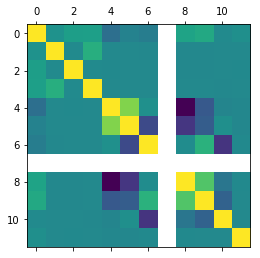

In [92]:
import matplotlib.pyplot as plt
 
plt.matshow(df_clean.corr())
plt.show()

In [93]:

corr = df_clean.corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


,offer_successful,age,tenure_days,income,difficulty,duration,reward,email,mobile,social,web,informational
offer_successful,1,0.078278,0.170745,0.177546,-0.19303,-0.0479985,-0.0855183,nan,0.211489,0.249337,0.0197014,0.055155
age,0.078278,1,0.0150655,0.293316,0.000428742,0.0053099,-0.00510762,nan,-0.00436259,-0.00586598,0.00423052,0.0012262
tenure_days,0.170745,0.0150655,1,0.0207555,0.00753239,0.00542994,0.000430988,nan,-0.00784709,-0.00657624,-0.000708497,0.0106976
income,0.177546,0.293316,0.0207555,1,-8.72661e-05,0.000185815,-0.000411115,nan,0.00232035,0.00448346,-0.00535004,0.00553581
difficulty,-0.19303,0.000428742,0.00753239,-8.72661e-05,1,0.643388,0.0622243,nan,-0.884594,-0.356751,-0.029149,-0.0101198
duration,-0.0479985,0.0053099,0.00542994,0.000185815,0.643388,1,-0.458254,nan,-0.583952,-0.325429,0.0560153,-0.0148465
reward,-0.0855183,-0.00510762,0.000430988,-0.000411115,0.0622243,-0.458254,1,nan,0.031997,0.320523,-0.600503,0.00711117
email,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mobile,0.211489,-0.00436259,-0.00784709,0.00232035,-0.884594,-0.583952,0.031997,nan,1,0.491284,-0.144274,0.00761601
social,0.249337,-0.00586598,-0.00657624,0.00448346,-0.356751,-0.325429,0.320523,nan,0.491284,1,-0.293667,0.00425641


## Prediction

In [94]:
X = df_clean[['age','gender','tenure_days','income','difficulty','duration','reward', 'email',
       'mobile', 'social', 'web', 'offer_type']]
y = df_clean['offer_successful']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [96]:
categorical_preprocessing = Pipeline(steps=[('One Hot Encoding',OneHotEncoder(handle_unknown='ignore'))])
numeric_preprocessing = Pipeline(steps=[('Scaling',StandardScaler())])

In [97]:
preprocessing = ColumnTransformer(transformers=[('num',numeric_preprocessing,['age','tenure_days','income','difficulty','duration','reward','email','mobile','social','web']),
                                         ('cat',categorical_preprocessing,['gender','offer_type'])])

In [98]:
clf = Pipeline(steps=[('preprocessing',preprocessing), ('classifier',LogisticRegression())])

In [99]:
clf.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('Scaling', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['age', 'tenure_days', 'income'...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [100]:
clf.score(X_train,y_train) 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.66974718504355213

In [101]:
clf.score(X_test,y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.68153576549306993

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


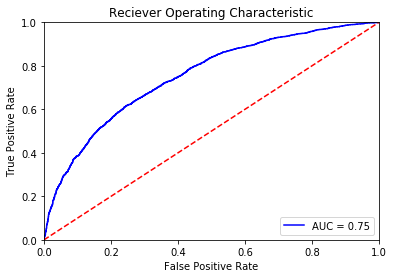

In [102]:
import sklearn.metrics as metrics
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr,tpr, threshold = metrics.roc_curve(y_test,preds)
roc_auc = metrics.auc(fpr,tpr)

import matplotlib.pyplot as plt
plt.title('Reciever Operating Characteristic')
plt.plot(fpr,tpr,'b',label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [103]:
predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [104]:
# train set
print(roc_auc_score(y_train, predictions_train))

0.666993436351


In [105]:
# test set
print(roc_auc_score(y_test, predictions))

0.678912233461


In [106]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.68      0.63      0.65      2971
           1       0.69      0.73      0.71      3306

   micro avg       0.68      0.68      0.68      6277
   macro avg       0.68      0.68      0.68      6277
weighted avg       0.68      0.68      0.68      6277



#### K-fold cross validation

In [107]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float

Accuracy: 0.672 (0.007)


/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [108]:
parameters_grid = {'classifier__penalty': ['l1','l2'], 
                      'classifier__C': [0.001,0.01,0.1,1,10],
                      }
cv = GridSearchCV(clf, param_grid=parameters_grid, scoring='f1_micro')
    

In [109]:
cv.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversi

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('Scaling', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['age', 'tenure_days', 'income'...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [110]:
predictions = cv.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [111]:
cv.score(X_train,y_train) 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.66980029742936054

In [112]:
cv.score(X_test,y_test) 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.68153576549306993

In [113]:
cv.best_params_

{'classifier__C': 10, 'classifier__penalty': 'l2'}

#### Optimizing the model and trying out another algorithm - Random Forest classifier

In [114]:
# RANDOM FOREST 

def build_model():
    """ 
    Build improved model with best parameters from gridsearch results cv.best_params_ 
    """
    
    categorical_preprocessing = Pipeline(steps=[('One Hot Encoding',OneHotEncoder(handle_unknown='ignore'))])
    numeric_preprocessing = Pipeline(steps=[('Scaling',StandardScaler())])

    preprocessing = ColumnTransformer(transformers=[('num',numeric_preprocessing,['age','tenure_days','income','difficulty','duration','reward','email','mobile','social','web']),
                                         ('cat',categorical_preprocessing,['gender','offer_type'])])
    
    pipeline = Pipeline(steps=[('preprocessing',preprocessing), ('classifier',RandomForestClassifier())])
    
    
    param_grid = {
    #'classifier__bootstrap': [True,False],
    'classifier__max_depth': [80, 90, 100, 110],
    #'classifier__max_features': [2, 3],
    'classifier__min_samples_leaf': [3, 4, 5],
    #'classifier__min_samples_split': [8, 10, 12],
    'classifier__n_estimators': [100, 200, 300, 1000]}


    cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='f1_micro')
    
    return cv

In [115]:
model = build_model()

In [116]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: Dat

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('Scaling', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['age', 'tenure_days', 'income'...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__max_depth': [80, 90, 100, 110], 'classifier__min_samples_leaf': [3, 4, 5], 'classifier__n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [117]:
model.best_params_

{'classifier__max_depth': 90,
 'classifier__min_samples_leaf': 5,
 'classifier__n_estimators': 200}

In [118]:
model.score(X_train,y_train) 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.82998725302740595

In [119]:
model.score(X_test,y_test) 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.71578779671817749

In [120]:
predictions = model.predict(X_test)
predictions_train = model.predict(X_train)

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


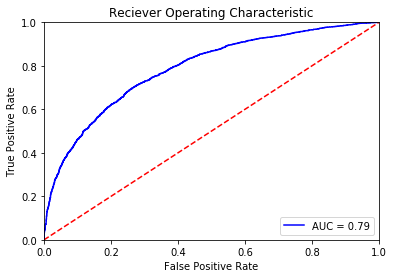

In [121]:
import sklearn.metrics as metrics
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr,tpr, threshold = metrics.roc_curve(y_test,preds)
roc_auc = metrics.auc(fpr,tpr)

import matplotlib.pyplot as plt
plt.title('Reciever Operating Characteristic')
plt.plot(fpr,tpr,'b',label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [122]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2971
           1       0.73      0.72      0.73      3306

   micro avg       0.72      0.72      0.72      6277
   macro avg       0.72      0.72      0.72      6277
weighted avg       0.72      0.72      0.72      6277



In [123]:
model.best_params_

{'classifier__max_depth': 90,
 'classifier__min_samples_leaf': 5,
 'classifier__n_estimators': 200}

In [124]:
model.best_params_

{'classifier__max_depth': 90,
 'classifier__min_samples_leaf': 5,
 'classifier__n_estimators': 200}

In [125]:
model.best_estimator_

Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('Scaling', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['age', 'tenure_days', 'income'...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [126]:
model.best_index_

21

In [127]:
# train set
print(roc_auc_score(y_train, predictions_train))

0.829649748149


In [128]:
# test set
print(roc_auc_score(y_test, predictions))

0.715282923473


#### K-fold cross validation

In [131]:
# rebuild the a logistic regression model with the optimized hyperparameters

def build_model2():
    """ 
    Build improved model with best parameters from gridsearch results cv.best_params_ 
    """
    
    categorical_preprocessing = Pipeline(steps=[('One Hot Encoding',OneHotEncoder(handle_unknown='ignore'))])
    numeric_preprocessing = Pipeline(steps=[('Scaling',StandardScaler())])

    preprocessing = ColumnTransformer(transformers=[('num',numeric_preprocessing,['age','tenure_days','income','difficulty','duration','reward','email','mobile','social','web']),
                                         ('cat',categorical_preprocessing,['gender','offer_type'])])
    
    pipeline = Pipeline(steps=[('preprocessing',preprocessing), ('classifier',RandomForestClassifier(max_depth=90,
                                                                                                    min_samples_leaf=5,
                                                                                                    n_estimators=200 ))])
    return pipeline

In [132]:
model2 = build_model2()

In [134]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(model2, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
#report performance 
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64,

Accuracy: 0.705 (0.010)


/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Exporting the model for use on other system

In [130]:
from sklearn.externals import joblib
joblib.dump(model.best_estimator_, 'model.pkl')

['model.pkl']